# Let's explore more data

In [1]:
!pip install matplotlib --upgrade

Requirement already up-to-date: matplotlib in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: numpy>=1.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: python-dateutil in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pytz in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: cycler in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.4,>=1.5.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Cleaning up...


In [2]:
#generic
%matplotlib inline
from __future__ import print_function

#public open pakcages and methods
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#private pakcages and methods
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter

#for testing
from IPython import display
import platform
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [68]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    for d in data_it:
        return_data.append(d[key])
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data = []
    date = []
    for share in share_list:
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data.append(map(float, get_data_by_key(key=data_type, data=hist_data)))
        date.append(get_data_by_key(key='Date', data=hist_data))
    return np.array(stock_data).T, date

In [88]:
class ESN(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        N_data = len(input_data)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, input_data[i]])\
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[i]))
                X.append(np.r_[1.0, input_data[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), input_data, middle_data]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data, sig=0):
        output_data = []
        N_data = len(input_data)
        #initalization
        middle = self.middle.copy()
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                                    + np.dot(self.W_middle, middle)) + sig*np.random.randn(self.N_middle)
            output = self.activation_out(np.dot(self.W_out, np.r_[1.0, input_data[i], new_m]))
            middle = new_m
            output_data.append(output)
            
        return np.array(output_data)

We will use data as follows

In [101]:
target_list = ['YHOO']

input_list = ["AAPL", "ORCL", "IBM", "INTC"]
energy = ["PTR", "XOM", "CVX", "RDS-A"]
financial = ["WFC", "JPM", "HSBC", "BAC"]
healthcare = ["NVX", "PFE", "MRK"]
hardware = ["AAPL", "ORCL", "IBM", "INTC"]
software = ["MSFT", "GOOGL", "FB"]
input_list = energy + financial + healthcare + hardware + software

In [106]:
start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data_pred, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

learning_time: 0.13392496109


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


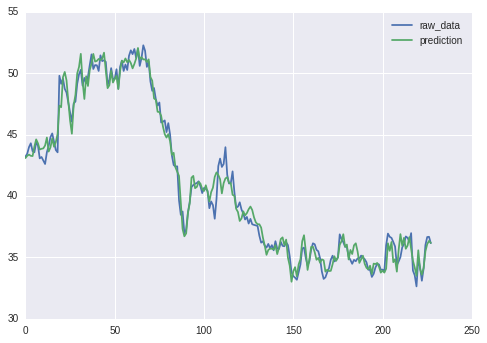

In [128]:
import time

T = len(input_data)
N_middle = T 
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-3)
elapsed = time.time() - st

print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data.T[0][start_time:], label="prediction")
plt.legend()

prediction time: 0.0405879020691


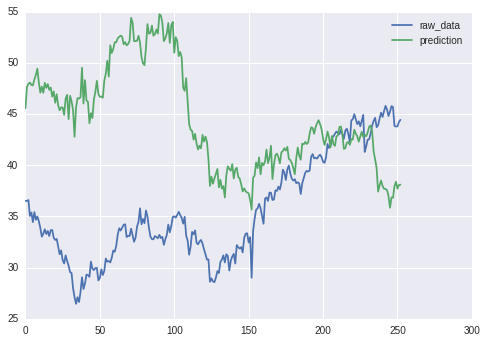

In [129]:
st = time.time()
output_data_pred = esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.2834341526


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


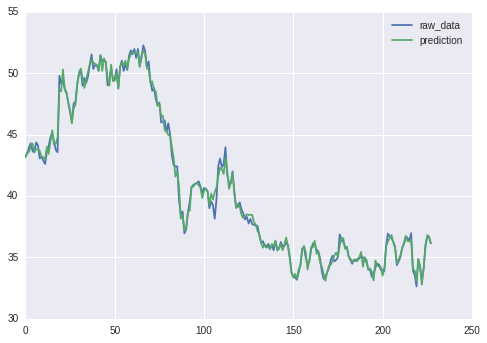

In [136]:
T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-3)
elapsed = time.time() - st

print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data.T[0][start_time:], label="prediction")
plt.legend()

prediction time: 0.587778806686


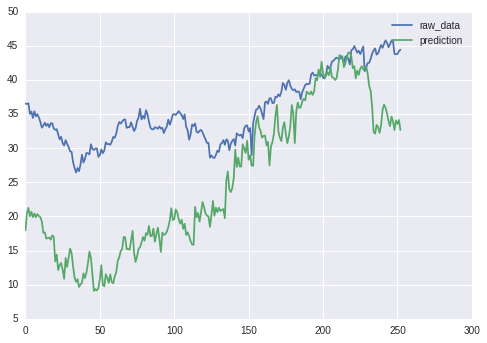

In [137]:
st = time.time()
output_data_pred = esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 57.7047119141


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


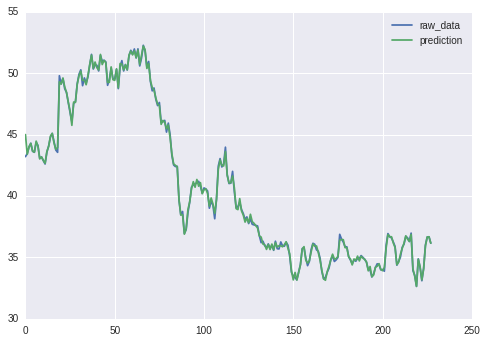

In [133]:
T = len(input_data)
N_middle = T * 10
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-3)
elapsed = time.time() - st

print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

prediction time: 2.22085905075


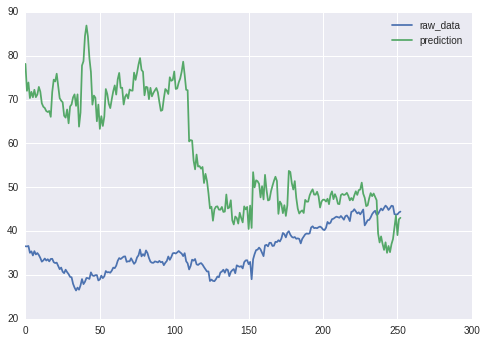

In [134]:
st = time.time()
output_data_pred = esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 0.135267019272


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


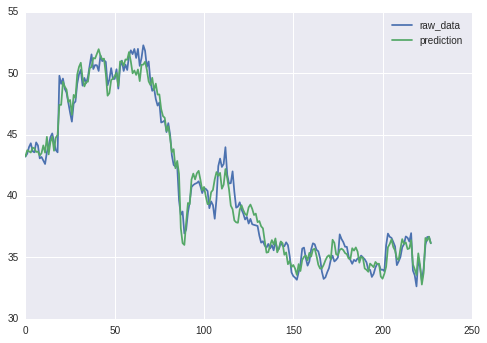

In [126]:
T = len(input_data)
N_middle = T 
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-3)
elapsed = time.time() - st

print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data.T[0][start_time:], label="prediction")
plt.legend()

prediction time: 0.0392291545868


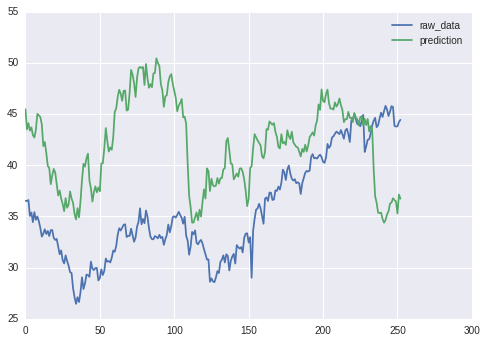

In [127]:
st = time.time()
output_data_pred = target_presn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Some Other Models